In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [3]:
method = "er"

In [15]:
gdf_de = gpd.read_file("https://raw.githubusercontent.com/okfde/wahldaten/master/geometrien/wahlkreise/wahlkreise.geojson")

df_de = pd.read_csv(f"data_output/Germany/2021_divisiveness_constituency_{method}.csv.gz", compression="gzip")
df_de = df_de.dropna()
df_de["value"] = df_de["value"] #/ len(df_de.candidate.unique())

gdf_de = gdf_de.rename(columns={"WKR_NR": "constituency"})

data_de = df_de.groupby(["constituency"]).agg({"value": "mean"}).reset_index()
data_de = pd.merge(data_de, gdf_de, on="constituency")

data_de = gpd.GeoDataFrame(data_de)

In [14]:
gdf_es = gpd.read_file("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/spain-provinces.geojson")
gdf_es["province_id"] = gdf_es["cod_prov"].astype(int)
gdf_es = gdf_es[~gdf_es["province_id"].isin([38, 35])]

df_es = pd.read_csv(f"data_output/Spain/2019_divisiveness_province_id_{method}.csv.gz", compression="gzip")
df_es = df_es.dropna()

df_es["value"] = df_es["value"] #/ len(df_es.candidate.unique())
gdf_de = gdf_es.rename(columns={"WKR_NR": "constituency"})

data_es = df_es.groupby(["province_id"]).agg({"value": "mean"}).reset_index()
data_es = pd.merge(data_es, gdf_es, on="province_id")

data_es = gpd.GeoDataFrame(data_es)

# data_es["value"] = NormalizeData(data_es["value"])

In [13]:
geography = "department_id"
gdf_fr = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson")
gdf_fr = gdf_fr.rename(columns={"nom": "department", "code": "department_id"})
gdf_fr["department_id"] = gdf_fr["department_id"].str.zfill(2)
df_fr = pd.read_csv(f"data_output/France/2022_divisiveness_{geography}_{method}.csv.gz", compression="gzip")
df_fr = df_fr.dropna()
df_fr["value"] = df_fr["value"] #/ len(df_fr.candidate.unique())
df_fr["department_id"] = df_fr["department_id"].str.zfill(2)

data_fr = df_fr.groupby([geography]).agg({"value": "mean"}).reset_index()
data_fr = pd.merge(data_fr, gdf_fr, on=geography)

data_fr = gpd.GeoDataFrame(data_fr)

# data_fr["value"] = NormalizeData(data_fr["value"])

In [12]:
gdf_it = gpd.read_file("https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson")
gdf_it = gdf_it.rename(columns={"prov_istat_code": "province_id"})

df_it = pd.read_csv(f"data_output/Italy/2022_divisiveness_province_id_{method}.csv.gz", compression="gzip")
df_it = df_it.dropna()
df_it["value"] = df_it["value"] #/ len(df_it.candidate.unique())

data_it = df_it.groupby(["province_id"]).agg({"value": "mean"}).reset_index()
data_it["province_id"] = data_it["province_id"].astype(str).str.zfill(3)
data_it = pd.merge(data_it, gdf_it, on="province_id")

data_it = gpd.GeoDataFrame(data_it)

# data_it["value"] = NormalizeData(data_it["value"])

In [16]:
data = pd.concat([
    data_es,
    data_fr,
    data_it,
    data_de
])

In [18]:
data_de.sort_values("value")

,constituency,value,WKR_NAME,LAND_NR,LAND_NAME,geometry
46,47,6.111418,Hannover-Land II,03,Niedersachsen,"POLYGON ((10.09133 52.52246, 10.09272 52.52218..."
7,8,6.361353,Segeberg  Stormarn-Mitte,01,Schleswig-Holstein,"MULTIPOLYGON (((10.10121 53.97246, 10.09906 53..."
259,260,6.402691,Böblingen,08,Baden-Württemberg,"MULTIPOLYGON (((8.88902 48.82856, 8.88948 48.8..."
296,297,6.463622,Saarlouis,10,Saarland,"POLYGON ((6.88754 49.61347, 6.88887 49.61326, ..."
110,111,6.467159,Viersen,05,Nordrhein-Westfalen,"POLYGON ((6.51861 51.42458, 6.52128 51.42434, ..."
...,...,...,...,...,...,...
151,152,13.840203,Leipzig I,14,Sachsen,"POLYGON ((12.50506 51.30364, 12.50304 51.30406..."
190,191,13.933636,Jena  Sömmerda  Weimarer Land I,16,Thüringen,"POLYGON ((11.08185 51.31900, 11.08687 51.31771..."
159,160,14.461626,Dresden II  Bautzen II,14,Sachsen,"POLYGON ((13.92274 51.20179, 13.92181 51.19994..."
18,19,15.380047,Hamburg-Altona,02,Hamburg,"POLYGON ((9.86970 53.61294, 9.87001 53.61274, ..."


In [10]:
data["value_2"] = NormalizeData(data["value"])

(-10.692476479954946,
 19.911470079053867,
 34.173646720017544,
 56.052894879631566)

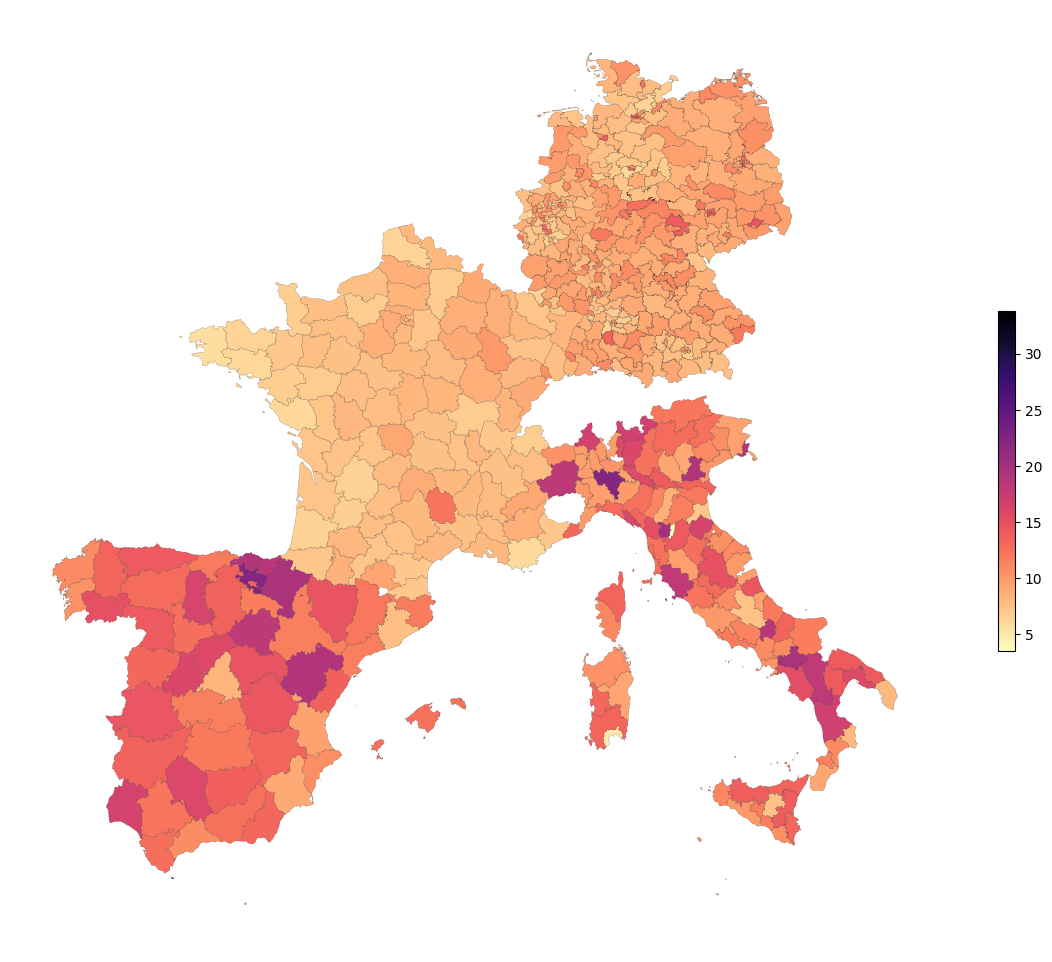

In [17]:
fig, ax = plt.subplots(figsize=(15, 15), dpi=100)

data.plot(
    column="value", ax=ax, 
    lw=0.1,
    legend=True, 
    edgecolor="black",
    cmap="magma_r",
    legend_kwds=dict(
        shrink=0.3
    ))

plt.axis("off")